# 01 - Data Quality Assessment

**NovaCred Credit Application Governance Analysis**

This notebook documents the data quality audit of the raw credit applications dataset.
We systematically identify, quantify, and remediate data quality issues across four
key dimensions: **completeness**, **consistency**, **validity**, and **accuracy**.

In [1]:
import sys
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import warnings
warnings.filterwarnings('ignore')

# add src to path so we can import our modules
sys.path.insert(0, '../src')
from data_loader import load_raw_json, load_and_flatten
from data_cleaning import clean_pipeline

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## 1. Load the Raw Data

The dataset is stored as a nested JSON file with 500+ credit application records.

In [2]:
# load raw json to inspect the nested structure
raw_data = load_raw_json('../data/raw_credit_applications.json')

print(f"Total records in raw file: {len(raw_data)}")
print(f"\nExample record structure:")
print(json.dumps(raw_data[0], indent=2, default=str))

Loaded 502 records from ../data/raw_credit_applications.json
Total records in raw file: 502

Example record structure:
{
  "_id": "app_200",
  "applicant_info": {
    "full_name": "Jerry Smith",
    "email": "jerry.smith17@hotmail.com",
    "ssn": "596-64-4340",
    "ip_address": "192.168.48.155",
    "gender": "Male",
    "date_of_birth": "2001-03-09",
    "zip_code": "10036"
  },
  "financials": {
    "annual_income": 73000,
    "credit_history_months": 23,
    "debt_to_income": 0.2,
    "savings_balance": 31212
  },
  "spending_behavior": [
    {
      "category": "Shopping",
      "amount": 480
    },
    {
      "category": "Rent",
      "amount": 790
    },
    {
      "category": "Alcohol",
      "amount": 247
    }
  ],
  "decision": {
    "loan_approved": false,
    "rejection_reason": "algorithm_risk_score"
  },
  "processing_timestamp": "2024-01-15T00:00:00Z"
}


In [3]:
# flatten the nested JSON into a DataFrame for analysis
df_raw = load_and_flatten('../data/raw_credit_applications.json')
df_raw.head()

Loaded 502 records from ../data/raw_credit_applications.json
DataFrame shape: (502, 22)


,app_id,full_name,email,ssn,ip_address,gender,date_of_birth,zip_code,annual_income,credit_history_months,...,spending_total,spending_categories,spending_category_list,loan_approved,interest_rate,approved_amount,rejection_reason,processing_timestamp,loan_purpose,notes
0,app_200,Jerry Smith,jerry.smith17@hotmail.com,596-64-4340,192.168.48.155,Male,2001-03-09,10036,73000,23,...,1517,3,Shopping|Rent|Alcohol,False,NaN,NaN,algorithm_risk_score,2024-01-15T00:00:00Z,NaN,NaN
1,app_037,Brandon Walker,brandon.walker2@yahoo.com,425-69-4784,10.1.102.112,M,1992-03-31,10032,78000,51,...,947,3,Rent|Dining|Healthcare,False,NaN,NaN,algorithm_risk_score,NaN,NaN,NaN
2,app_215,Scott Moore,scott.moore94@mail.com,370-78-5178,10.240.193.250,Male,1989-10-24,10075,61000,41,...,109,1,Rent,True,3.7,59000.0,NaN,NaN,vacation,NaN
3,app_024,Thomas Lee,thomas.lee6@protonmail.com,194-35-1833,192.168.175.67,Male,1983-04-25,10077,103000,70,...,575,1,Fitness,True,4.3,34000.0,NaN,NaN,NaN,NaN
4,app_184,Brian Rodriguez,brian.rodriguez86@aol.com,480-41-2475,172.29.125.105,M,1999-05-21,10080,57000,14,...,463,1,Entertainment,False,NaN,NaN,algorithm_risk_score,2024-01-15T00:00:00Z,NaN,NaN


In [4]:
df_raw.info()

<class 'pandas.DataFrame'>
RangeIndex: 502 entries, 0 to 501
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   app_id                  502 non-null    str    
 1   full_name               502 non-null    str    
 2   email                   502 non-null    str    
 3   ssn                     497 non-null    str    
 4   ip_address              497 non-null    str    
 5   gender                  501 non-null    str    
 6   date_of_birth           501 non-null    str    
 7   zip_code                501 non-null    str    
 8   annual_income           497 non-null    object 
 9   credit_history_months   502 non-null    int64  
 10  debt_to_income          502 non-null    float64
 11  savings_balance         502 non-null    int64  
 12  spending_total          502 non-null    int64  
 13  spending_categories     502 non-null    int64  
 14  spending_category_list  502 non-null    str    
 15  

## 2. Data Quality Issues — Overview

We now go through each data quality dimension and document all issues found.

Our plan is to check the dataset across four key quality dimensions:
- **Completeness** — are all expected fields present and populated?
- **Consistency** — are values formatted uniformly (e.g., dates, gender codes)?
- **Validity** — are values within expected/possible ranges?
- **Accuracy** — are there duplicate entries or conflicting records?

We'll also look at any **privacy** concerns related to the types of data being collected.

## 3. Issue 1: Duplicate Records

We check for records that share the same application ID.

In [5]:
# check for duplicate IDs
id_counts = df_raw['app_id'].value_counts()
duplicates = id_counts[id_counts > 1]

print(f"Total records: {len(df_raw)}")
print(f"Unique IDs: {df_raw['app_id'].nunique()}")
print(f"\nDuplicate IDs:")
print(duplicates)

Total records: 502
Unique IDs: 500

Duplicate IDs:
app_id
app_042    2
app_001    2
Name: count, dtype: int64


In [6]:
# look at the duplicate records in detail
dup_ids = duplicates.index.tolist()
dup_records = df_raw[df_raw['app_id'].isin(dup_ids)]
dup_records[['app_id', 'full_name', 'email', 'ssn', 'annual_income', 'loan_approved', 'notes']]

,app_id,full_name,email,ssn,annual_income,loan_approved,notes
8,app_042,Joseph Lopez,joseph.lopez1@gmail.com,652-70-5530,69000,False,NaN
354,app_042,Joseph Lopez,joseph.lopez1@gmail.com,652-70-5530,69000,False,RESUBMISSION
383,app_001,Stephanie Nguyen,stephanie.nguyen47@mail.com,427-90-1892,102000,False,NaN
455,app_001,Stephanie Nguyen,stephanie.nguyen47@mail.com,NaN,102000,False,DUPLICATE_ENTRY_ERROR


**Findings:**
- `app_042` (Joseph Lopez): Exact duplicate. One copy has `notes: RESUBMISSION`
- `app_001` (Stephanie Nguyen): Near duplicate. One copy has `notes: DUPLICATE_ENTRY_ERROR` and is missing SSN and other fields

**Remediation:** Remove the records flagged with `RESUBMISSION` and `DUPLICATE_ENTRY_ERROR` notes.

## 4. Issue 2: Inconsistent Gender Coding

Gender values should use a single consistent format.

In [7]:
# check all gender values
gender_counts = df_raw['gender'].value_counts(dropna=False)
print("Gender value distribution:")
print(gender_counts)
print(f"\nTotal unique gender representations: {df_raw['gender'].nunique(dropna=False)}")

Gender value distribution:
gender
Male      195
Female    193
F          58
M          53
            2
NaN         1
Name: count, dtype: int64

Total unique gender representations: 6


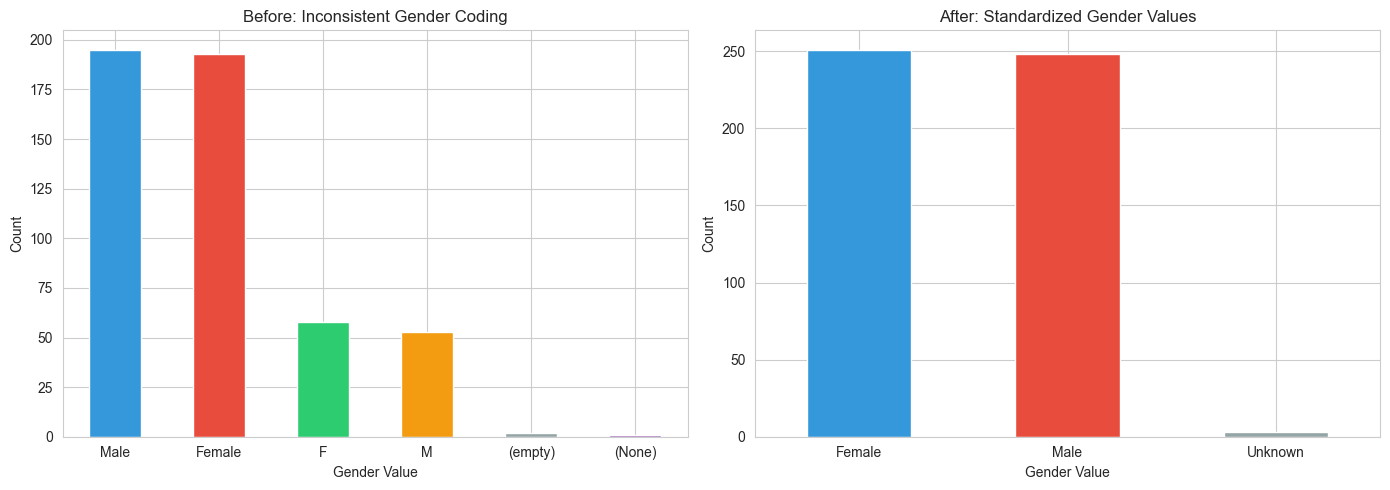


Records affected by inconsistent coding: 114


In [9]:
# visualize the inconsistency
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# before standardization
gender_display = df_raw['gender'].fillna('(None)').replace('', '(empty)')
gender_display.value_counts().plot(kind='bar', ax=ax1, color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#95a5a6', '#9b59b6'])
ax1.set_title('Before: Inconsistent Gender Coding')
ax1.set_xlabel('Gender Value')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=0)

# what it should look like after
gender_map = {'Male': 'Male', 'M': 'Male', 'Female': 'Female', 'F': 'Female'}
gender_std = df_raw['gender'].map(gender_map).fillna('Unknown')
gender_std.value_counts().plot(kind='bar', ax=ax2, color=['#3498db', '#e74c3c', '#95a5a6'])
ax2.set_title('After: Standardized Gender Values')
ax2.set_xlabel('Gender Value')
ax2.set_ylabel('Count')
ax2.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig('../reports/gender_standardization.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nRecords affected by inconsistent coding: {(df_raw['gender'].isin(['M', 'F', '', None]) | df_raw['gender'].isna()).sum()}")

**Findings:**
- 6 different gender representations: `Male`, `M`, `Female`, `F`, empty string, `None`
- 114 records use abbreviated form (M/F) instead of full form
- 3 records have missing/empty gender

**Remediation:** Map `M` → `Male`, `F` → `Female`, empty/None → `NaN`

## 5. Issue 3: Inconsistent Date Formats

Let's check if dates of birth are stored in a consistent format across the dataset.

In [10]:
# classify the date formats
def classify_date_format(val):
    if pd.isna(val) or val == '' or val == 'None':
        return 'Missing'
    val = str(val).strip()
    if not val:
        return 'Missing'
    if '-' in val:
        return 'ISO (YYYY-MM-DD)'
    if '/' in val:
        parts = val.split('/')
        if len(parts[0]) == 4:
            return 'YYYY/MM/DD'
        elif int(parts[0]) > 12:
            return 'DD/MM/YYYY'
        elif int(parts[1]) > 12:
            return 'MM/DD/YYYY'
        else:
            return 'DD/MM/YYYY (ambiguous)'
    return 'Unknown'

df_raw['date_format'] = df_raw['date_of_birth'].apply(classify_date_format)
format_counts = df_raw['date_format'].value_counts()
print("Date format distribution:")
print(format_counts)

Date format distribution:
date_format
ISO (YYYY-MM-DD)          340
YYYY/MM/DD                 56
DD/MM/YYYY (ambiguous)     39
DD/MM/YYYY                 36
MM/DD/YYYY                 26
Missing                     5
Name: count, dtype: int64


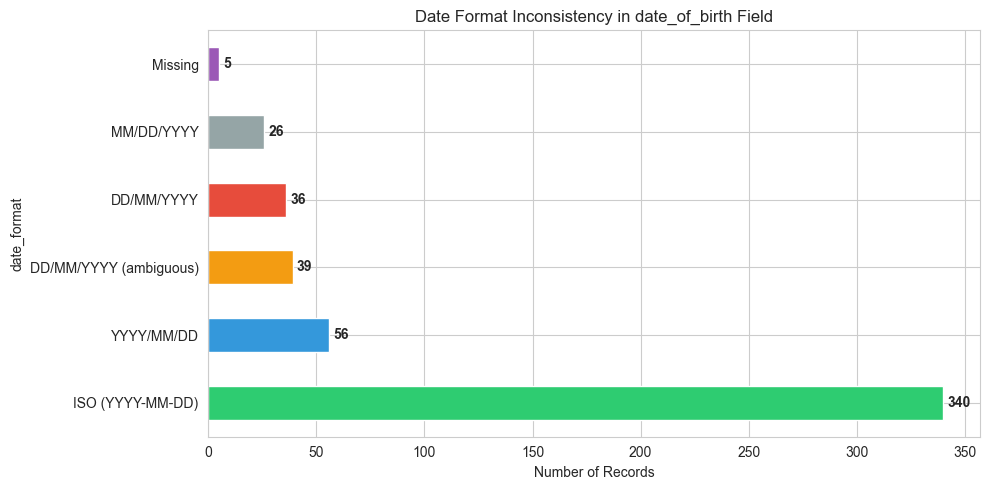


Examples of each format:
  ISO (YYYY-MM-DD): ['2001-03-09', '1992-03-31', '1989-10-24']
  YYYY/MM/DD: ['1990/07/26', '1986/11/20', '1995/05/07']
  DD/MM/YYYY (ambiguous): ['01/12/1978', '03/10/1981', '04/08/1979']
  DD/MM/YYYY: ['14/02/1982', '28/01/1990', '18/07/1979']
  MM/DD/YYYY: ['03/20/1968', '04/20/1994', '12/16/1985']
  Missing: ['', '', '']


In [11]:
# visualize date format distribution
fig, ax = plt.subplots(figsize=(10, 5))
colors = ['#2ecc71', '#3498db', '#f39c12', '#e74c3c', '#95a5a6', '#9b59b6']
format_counts.plot(kind='barh', ax=ax, color=colors[:len(format_counts)])
ax.set_title('Date Format Inconsistency in date_of_birth Field')
ax.set_xlabel('Number of Records')
for i, v in enumerate(format_counts.values):
    ax.text(v + 2, i, str(v), va='center', fontweight='bold')
plt.tight_layout()
plt.savefig('../reports/date_formats.png', dpi=150, bbox_inches='tight')
plt.show()

# show examples of each format
print("\nExamples of each format:")
for fmt in format_counts.index:
    examples = df_raw[df_raw['date_format'] == fmt]['date_of_birth'].head(3).tolist()
    print(f"  {fmt}: {examples}")

**Findings:**
- 4 distinct date formats used across the dataset
- 39 records are ambiguous (both day and month ≤ 12, could be DD/MM or MM/DD)
- 4-5 records have completely missing dates

**Remediation:** Parse all formats into a unified `datetime` format. For ambiguous cases, default to DD/MM/YYYY (more common pattern in the dataset).

## 6. Issue 4: Data Type Mismatches — Annual Income

Some income values are stored as strings instead of numbers.

In [12]:
# check the types of annual_income in the raw data
income_types = Counter()
string_incomes = []
float_incomes = []
null_incomes = []

for record in raw_data:
    inc = record.get('financials', {}).get('annual_income')
    type_name = type(inc).__name__
    income_types[type_name] += 1
    if isinstance(inc, str):
        string_incomes.append((record['_id'], inc))
    elif isinstance(inc, float):
        float_incomes.append((record['_id'], inc))
    elif inc is None:
        null_incomes.append(record['_id'])

print("Income data types in raw JSON:")
for t, count in income_types.most_common():
    print(f"  {t}: {count}")

print(f"\nIncomes stored as STRING (should be int):")
for app_id, val in string_incomes:
    print(f"  {app_id}: '{val}'")

print(f"\nIncomes stored as FLOAT (excessive precision):")
for app_id, val in float_incomes:
    print(f"  {app_id}: {val}")

print(f"\nRecords with MISSING income:")
for app_id in null_incomes:
    print(f"  {app_id}")

Income data types in raw JSON:
  int: 488
  str: 8
  NoneType: 5
  float: 1

Incomes stored as STRING (should be int):
  app_088: '55000'
  app_135: '65000'
  app_446: '73000'
  app_389: '51000'
  app_026: '72000'
  app_312: '80000'
  app_180: '111000'
  app_224: '93000'

Incomes stored as FLOAT (excessive precision):
  app_311: 85432.789123

Records with MISSING income:
  app_436
  app_421
  app_479
  app_463
  app_449


**Findings:**
- 8 records have income stored as a string (e.g., `'55000'` instead of `55000`)
- 1 record has excessive decimal precision (`85432.789123`)
- 5 records have `null` income

**Remediation:** Convert all to numeric, round to integers, keep nulls as NaN.

## 7. Issue 5-6: Invalid Values (Negative Credit History & Savings)

Some numeric fields contain impossible negative values.

In [13]:
# check for negative credit history months
neg_ch = df_raw[df_raw['credit_history_months'] < 0]
print(f"Records with negative credit_history_months: {len(neg_ch)}")
print(neg_ch[['app_id', 'full_name', 'credit_history_months', 'loan_approved']])

print()

# check for negative savings balance
neg_sb = df_raw[df_raw['savings_balance'] < 0]
print(f"Records with negative savings_balance: {len(neg_sb)}")
print(neg_sb[['app_id', 'full_name', 'savings_balance', 'loan_approved']])

Records with negative credit_history_months: 2
      app_id      full_name  credit_history_months  loan_approved
137  app_043    Daniel King                    -10           True
162  app_156  Jessica Green                     -3          False

Records with negative savings_balance: 1
      app_id        full_name  savings_balance  loan_approved
159  app_290  Stephanie Perez            -5000           True


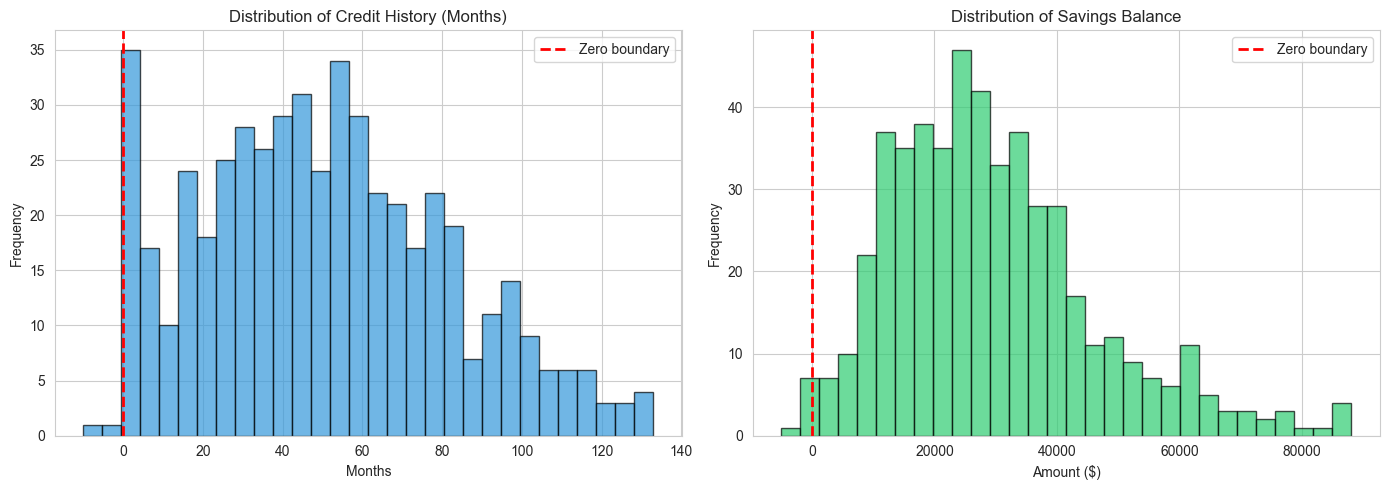

In [14]:
# visualize the distribution of credit history months to show the outliers
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.hist(df_raw['credit_history_months'].dropna(), bins=30, color='#3498db', edgecolor='black', alpha=0.7)
ax1.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero boundary')
ax1.set_title('Distribution of Credit History (Months)')
ax1.set_xlabel('Months')
ax1.set_ylabel('Frequency')
ax1.legend()

ax2.hist(df_raw['savings_balance'].dropna(), bins=30, color='#2ecc71', edgecolor='black', alpha=0.7)
ax2.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero boundary')
ax2.set_title('Distribution of Savings Balance')
ax2.set_xlabel('Amount ($)')
ax2.set_ylabel('Frequency')
ax2.legend()

plt.tight_layout()
plt.savefig('../reports/invalid_values.png', dpi=150, bbox_inches='tight')
plt.show()

**Findings:**
- `app_043`: credit_history_months = **-10** (impossible)
- `app_156`: credit_history_months = **-3** (impossible)
- `app_290`: savings_balance = **-5000** (impossible for a standard savings account)

**Remediation:** Set negative values to NaN since we can't determine the correct value.

## 8. Issue 7: Missing/Incomplete Records

Some records are missing critical fields like SSN, IP address, email, etc.

In [15]:
# check which fields have missing/empty values
def count_missing(series):
    """Count nulls and empty strings."""
    return series.isna().sum() + (series == '').sum()

core_fields = ['full_name', 'email', 'ssn', 'ip_address', 'gender', 
               'date_of_birth', 'zip_code', 'annual_income',
               'credit_history_months', 'debt_to_income', 'savings_balance']

missing_summary = pd.DataFrame({
    'field': core_fields,
    'missing_count': [count_missing(df_raw[f]) for f in core_fields],
    'missing_pct': [count_missing(df_raw[f]) / len(df_raw) * 100 for f in core_fields]
})
missing_summary = missing_summary.sort_values('missing_count', ascending=False)
missing_summary

,field,missing_count,missing_pct
1,email,7,1.394422
2,ssn,5,0.996016
3,ip_address,5,0.996016
7,annual_income,5,0.996016
5,date_of_birth,5,0.996016
4,gender,3,0.597610
6,zip_code,2,0.398406
0,full_name,0,0.000000
8,credit_history_months,0,0.000000
9,debt_to_income,0,0.000000


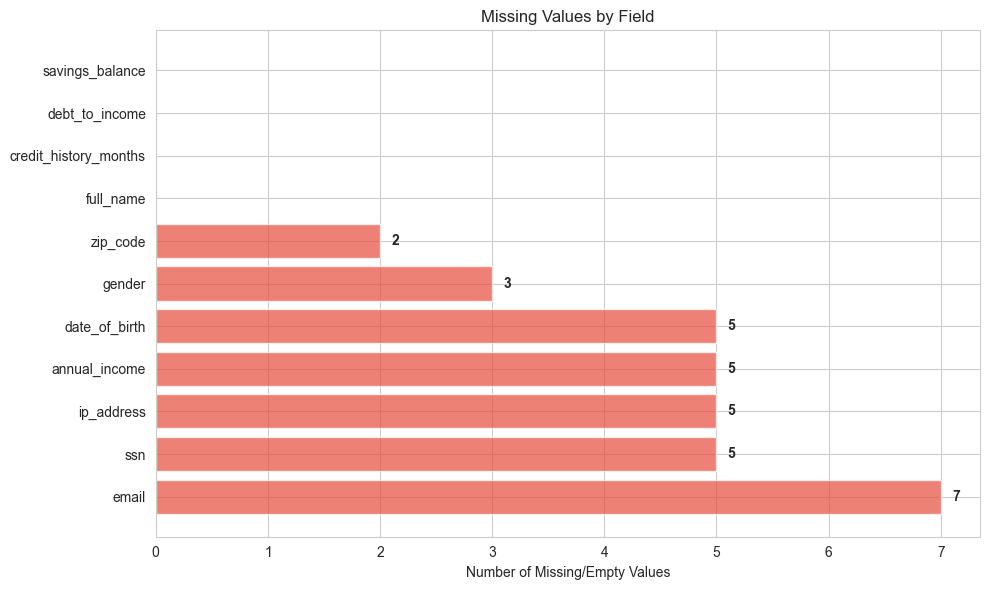

In [16]:
# visualize missing data
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(missing_summary['field'], missing_summary['missing_count'], color='#e74c3c', alpha=0.7)
ax.set_title('Missing Values by Field')
ax.set_xlabel('Number of Missing/Empty Values')
for bar, count in zip(bars, missing_summary['missing_count'].values):
    if count > 0:
        ax.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
                str(count), va='center', fontweight='bold')
plt.tight_layout()
plt.savefig('../reports/missing_values.png', dpi=150, bbox_inches='tight')
plt.show()

In [17]:
# look at the most incomplete records
incomplete_mask = (
    df_raw['ssn'].isna() | (df_raw['ssn'] == '') | 
    df_raw['ip_address'].isna() | (df_raw['ip_address'] == '') |
    df_raw['email'].isna() | (df_raw['email'] == '') |
    df_raw['gender'].isna() | (df_raw['gender'] == '')
)
incomplete = df_raw[incomplete_mask]
print(f"Records with critical missing fields: {len(incomplete)}")
incomplete[['app_id', 'full_name', 'email', 'ssn', 'ip_address', 'gender', 'date_of_birth', 'zip_code']].fillna('(NULL)')

Records with critical missing fields: 8


,app_id,full_name,email,ssn,ip_address,gender,date_of_birth,zip_code
26,app_075,Margaret Williams,,(NULL),(NULL),,,
187,app_413,Anthony Jackson,,584-37-2562,172.20.164.12,Male,1986-10-21,10044
275,app_120,Carolyn Martin,,(NULL),(NULL),Female,,90240
297,app_268,Larry Williams,,(NULL),(NULL),,1971-05-14,10005
298,app_377,Anna White,,617-17-3415,192.168.111.167,Female,1990-09-26,90237
448,app_350,Linda Adams,,356-98-8263,10.207.183.196,Female,,90291
455,app_001,Stephanie Nguyen,stephanie.nguyen47@mail.com,(NULL),(NULL),(NULL),(NULL),(NULL)
462,app_165,Brandon Moore,,(NULL),(NULL),Male,,10077


**Findings:**
- 5 records missing SSN and IP address (app_075, app_120, app_268, app_001, app_165)
- app_075 is particularly incomplete: missing email, gender, DOB, zip code, SSN, IP
- app_001 (the duplicate) is also missing many fields
- 5 records missing annual_income entirely

**Remediation:** Flag incomplete records with a completeness score. Don't impute PII.

## 9. Issue 8: Invalid Email Addresses

In [18]:
# validate email format using regex
email_pattern = re.compile(r'^[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}$')

def check_email(val):
    if pd.isna(val) or val == '':
        return 'Missing'
    if not email_pattern.match(str(val)):
        return 'Invalid'
    return 'Valid'

df_raw['email_status'] = df_raw['email'].apply(check_email)
print("Email validation results:")
print(df_raw['email_status'].value_counts())

print("\nInvalid emails:")
invalid_emails = df_raw[df_raw['email_status'] != 'Valid'][['app_id', 'email', 'email_status']]
invalid_emails

Email validation results:
email_status
Valid      491
Missing      7
Invalid      4
Name: count, dtype: int64

Invalid emails:


,app_id,email,email_status
26,app_075,,Missing
138,app_204,mike johnson@gmail.com,Invalid
181,app_299,test.user.outlook.com,Invalid
187,app_413,,Missing
275,app_120,,Missing
276,app_068,john.doe@invalid,Invalid
297,app_268,,Missing
298,app_377,,Missing
369,app_146,sarah.smith@,Invalid
448,app_350,,Missing


**Findings:**
- 6 empty email addresses
- `mike johnson@gmail.com` — space in local part
- `test.user.outlook.com` — missing `@` symbol
- `john.doe@invalid` — missing TLD
- `sarah.smith@` — missing domain

**Remediation:** Flag invalid emails (can't auto-correct without contacting applicant).

## 10. Issue 9: Duplicate SSNs on Different People

This is a critical data integrity issue: two different applicants sharing the same SSN.

In [19]:
# find SSNs that appear on multiple different people
# first remove empty/null SSNs
ssn_valid = df_raw[df_raw['ssn'].notna() & (df_raw['ssn'] != '')]
ssn_counts = ssn_valid['ssn'].value_counts()
dup_ssns = ssn_counts[ssn_counts > 1]

print(f"SSNs appearing more than once: {len(dup_ssns)}")
print()

for ssn in dup_ssns.index:
    records = df_raw[df_raw['ssn'] == ssn]
    # check if they're actually different people (not just the duplicate app_ids)
    unique_names = records['full_name'].nunique()
    if unique_names > 1:
        print(f"CRITICAL: SSN {ssn} used by {unique_names} DIFFERENT applicants:")
        print(records[['app_id', 'full_name', 'email', 'gender', 'date_of_birth']].to_string())
        print()

SSNs appearing more than once: 3

CRITICAL: SSN 937-72-8731 used by 2 DIFFERENT applicants:
      app_id     full_name                         email  gender date_of_birth
16   app_101  Sandra Smith     sandra.smith99@icloud.com  Female    1997-03-23
499  app_234   Samuel Hill  samuel.hill67@protonmail.com    Male    1976/01/29

CRITICAL: SSN 780-24-9300 used by 2 DIFFERENT applicants:
      app_id       full_name                            email gender date_of_birth
92   app_088  Susan Martinez  susan.martinez83@protonmail.com      F    1986-10-15
122  app_016     Gary Wilson          gary.wilson85@yahoo.com      M    1959-12-11



**Findings:**
- SSN `937-72-8731` is shared between **Sandra Smith** (app_101) and **Samuel Hill** (app_234) 
- SSN `780-24-9300` is shared between **Susan Martinez** (app_088) and **Gary Wilson** (app_016)

This is a critical data integrity issue that could indicate identity fraud, data entry errors, or system bugs.

**Remediation:** Flag these records for manual review. Can't auto-correct.

## 11. Issue 10: Schema Inconsistency

Some records have extra fields that others don't.

In [20]:
# check which optional fields are present
optional_fields = ['processing_timestamp', 'loan_purpose', 'notes']

for field in optional_fields:
    non_null = df_raw[field].notna() & (df_raw[field] != '')
    count = non_null.sum()
    pct = count / len(df_raw) * 100
    print(f"{field}: present in {count} records ({pct:.1f}%)")

print(f"\nRecords with processing_timestamp: ~{(df_raw['processing_timestamp'].notna() & (df_raw['processing_timestamp'] != '')).sum()}")
print(f"Records with loan_purpose: ~{(df_raw['loan_purpose'].notna() & (df_raw['loan_purpose'] != '')).sum()}")
print(f"Records with notes: {(df_raw['notes'].notna() & (df_raw['notes'] != '')).sum()}")

processing_timestamp: present in 62 records (12.4%)
loan_purpose: present in 50 records (10.0%)
notes: present in 2 records (0.4%)

Records with processing_timestamp: ~62
Records with loan_purpose: ~50
Records with notes: 2


**Findings:**
- `processing_timestamp` only present on ~60 records (12%)
- `loan_purpose` only present on ~50 records (10%)
- `notes` only on 2 records (the duplicates)

This inconsistency suggests the schema evolved over time or data came from multiple sources.

## 12. Issue 11: Sensitive Spending Categories

Some spending categories contain sensitive behavioral data that raises privacy concerns.

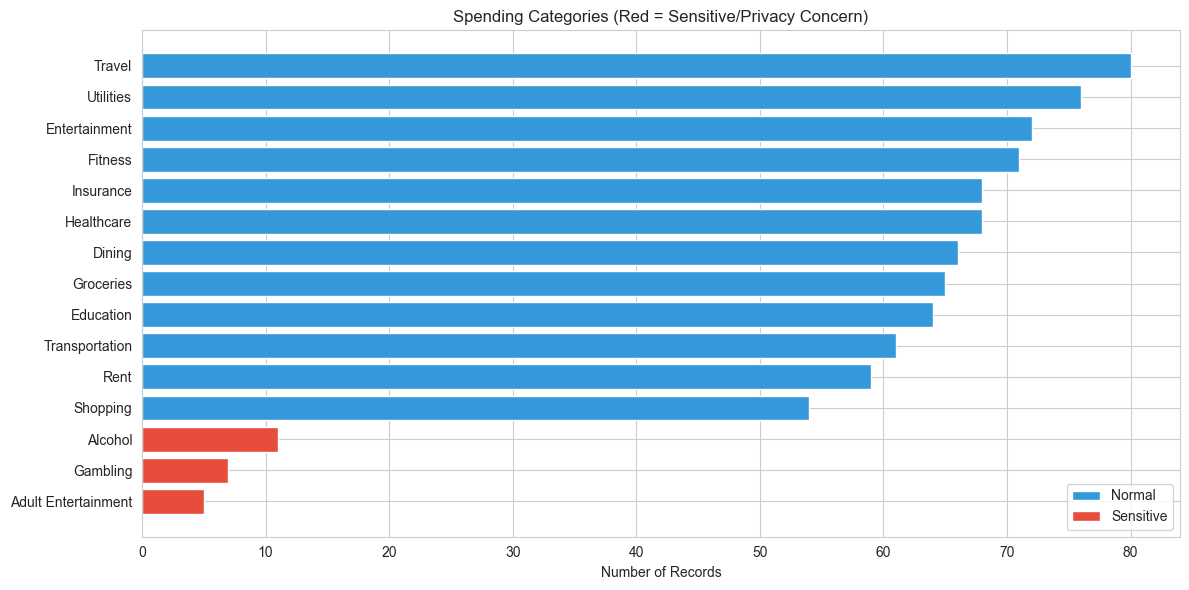


Sensitive categories found:
  Alcohol: 11 records
  Adult Entertainment: 5 records
  Gambling: 7 records


In [21]:
# parse all spending categories across the dataset
all_categories = []
for cats in df_raw['spending_category_list']:
    if pd.notna(cats) and cats != '':
        all_categories.extend(cats.split('|'))

cat_counts = Counter(all_categories)

# classify categories
sensitive_cats = {'Alcohol', 'Gambling', 'Adult Entertainment'}

fig, ax = plt.subplots(figsize=(12, 6))
cat_df = pd.DataFrame(cat_counts.items(), columns=['Category', 'Count']).sort_values('Count', ascending=True)
colors = ['#e74c3c' if cat in sensitive_cats else '#3498db' for cat in cat_df['Category']]
ax.barh(cat_df['Category'], cat_df['Count'], color=colors)
ax.set_title('Spending Categories (Red = Sensitive/Privacy Concern)')
ax.set_xlabel('Number of Records')

# add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#3498db', label='Normal'),
                   Patch(facecolor='#e74c3c', label='Sensitive')]
ax.legend(handles=legend_elements)

plt.tight_layout()
plt.savefig('../reports/spending_categories.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nSensitive categories found:")
for cat in sensitive_cats:
    count = cat_counts.get(cat, 0)
    print(f"  {cat}: {count} records")

**Findings:**
- **Alcohol** spending tracked for 11 records
- **Gambling** tracked for 7 records
- **Adult Entertainment** tracked for 5 records

Collecting this type of sensitive behavioral data raises serious privacy and governance concerns:
- Under GDPR, this could be considered sensitive data requiring explicit consent
- Using it in credit decisions could be discriminatory
- It violates data minimization principles (is this data necessary for credit decisions?)

## 13. Run the Cleaning Pipeline

Now we apply all remediations using our cleaning pipeline from `src/data_cleaning.py`.

In [22]:
# run the full cleaning pipeline
df_raw_fresh = load_and_flatten('../data/raw_credit_applications.json')
df_clean = clean_pipeline(df_raw_fresh)

Loaded 502 records from ../data/raw_credit_applications.json
DataFrame shape: (502, 22)
STARTING DATA CLEANING PIPELINE
Removed 2 duplicate records (502 -> 500)
Gender standardization complete:
gender
Female    251
Male      247
NaN         2
Name: count, dtype: int64

Date normalization: 496 valid, 4 missing/unparseable
Income type fix: 5 missing values remain
Found 2 negative credit_history_months -> setting to NaN
Found 1 negative savings_balance -> setting to NaN
Email validation: 11 invalid emails flagged
Completeness: 15 records have missing core fields
Flagged 2 SSNs appearing on multiple different applicants
CLEANING COMPLETE — 500 records


In [23]:
# compare before and after
print("=" * 50)
print("BEFORE vs AFTER CLEANING")
print("=" * 50)
print(f"Records: {len(df_raw)} -> {len(df_clean)} (removed {len(df_raw) - len(df_clean)} duplicates)")
print(f"Gender values: {df_raw['gender'].nunique(dropna=False)} different -> {df_clean['gender'].nunique(dropna=False)} (Male/Female/NaN)")
print(f"Valid dates: {df_raw['date_of_birth'].apply(lambda x: pd.notna(x) and x != '' and x != 'None').sum()} parsed -> {df_clean['date_of_birth'].notna().sum()} datetime objects")
print(f"Income type: mixed (str/int/float/null) -> numeric (float64), {df_clean['annual_income'].isna().sum()} NaN")
print(f"Negative values fixed: credit_history_months ({(df_raw['credit_history_months'] < 0).sum()} -> {(df_clean['credit_history_months'] < 0).sum()})")
print(f"Emails validated: {(~df_clean['email_valid']).sum()} flagged as invalid")
print(f"SSN integrity: {df_clean['ssn_duplicate_flag'].sum()} records flagged for duplicate SSNs")

BEFORE vs AFTER CLEANING
Records: 502 -> 500 (removed 2 duplicates)
Gender values: 6 different -> 3 (Male/Female/NaN)
Valid dates: 497 parsed -> 496 datetime objects
Income type: mixed (str/int/float/null) -> numeric (float64), 5 NaN
Negative values fixed: credit_history_months (2 -> 0)
Emails validated: 11 flagged as invalid
SSN integrity: 4 records flagged for duplicate SSNs


In [24]:
# save the cleaned dataset
df_clean.to_csv('../data/cleaned_credit_applications.csv', index=False)
print(f"Saved cleaned dataset: {len(df_clean)} records, {len(df_clean.columns)} columns")
print(f"Output: ../data/cleaned_credit_applications.csv")

Saved cleaned dataset: 500 records, 28 columns
Output: ../data/cleaned_credit_applications.csv


## 14. Data Quality Summary

### Quality Dimensions Mapping

| Dimension | Issues Found | Count |
|-----------|-------------|-------|
| **Completeness** | Missing SSN/IP (5 records), missing income (5), missing DOB (4), missing gender (3) | 17 records affected |
| **Consistency** | Gender coding (6 variants), date formats (4 formats), income types (str/int/float), inconsistent schema | ~270 records affected |
| **Validity** | Negative credit history (2), negative savings (1), invalid emails (11) | 14 records affected |
| **Accuracy** | Duplicate records (2 pairs), duplicate SSNs across people (2 pairs), excessive precision income (1) | 7 records affected |

### Remediation Summary

| Action | Method | Records Fixed |
|--------|--------|---------------|
| Remove duplicates | Drop records with DUPLICATE_ENTRY_ERROR/RESUBMISSION notes | 2 |
| Standardize gender | Map M→Male, F→Female, empty→NaN | 114 |
| Normalize dates | Parse all 4 formats into datetime | 497 → 496 unified |
| Fix income types | Convert string to numeric, round float | 9 |
| Handle negatives | Set impossible negatives to NaN | 3 |
| Validate emails | Flag (not auto-correct) invalid formats | 11 flagged |
| Flag SSN issues | Mark cross-person SSN duplicates | 4 flagged |
| Completeness score | Added per-record completeness metric | All records scored |

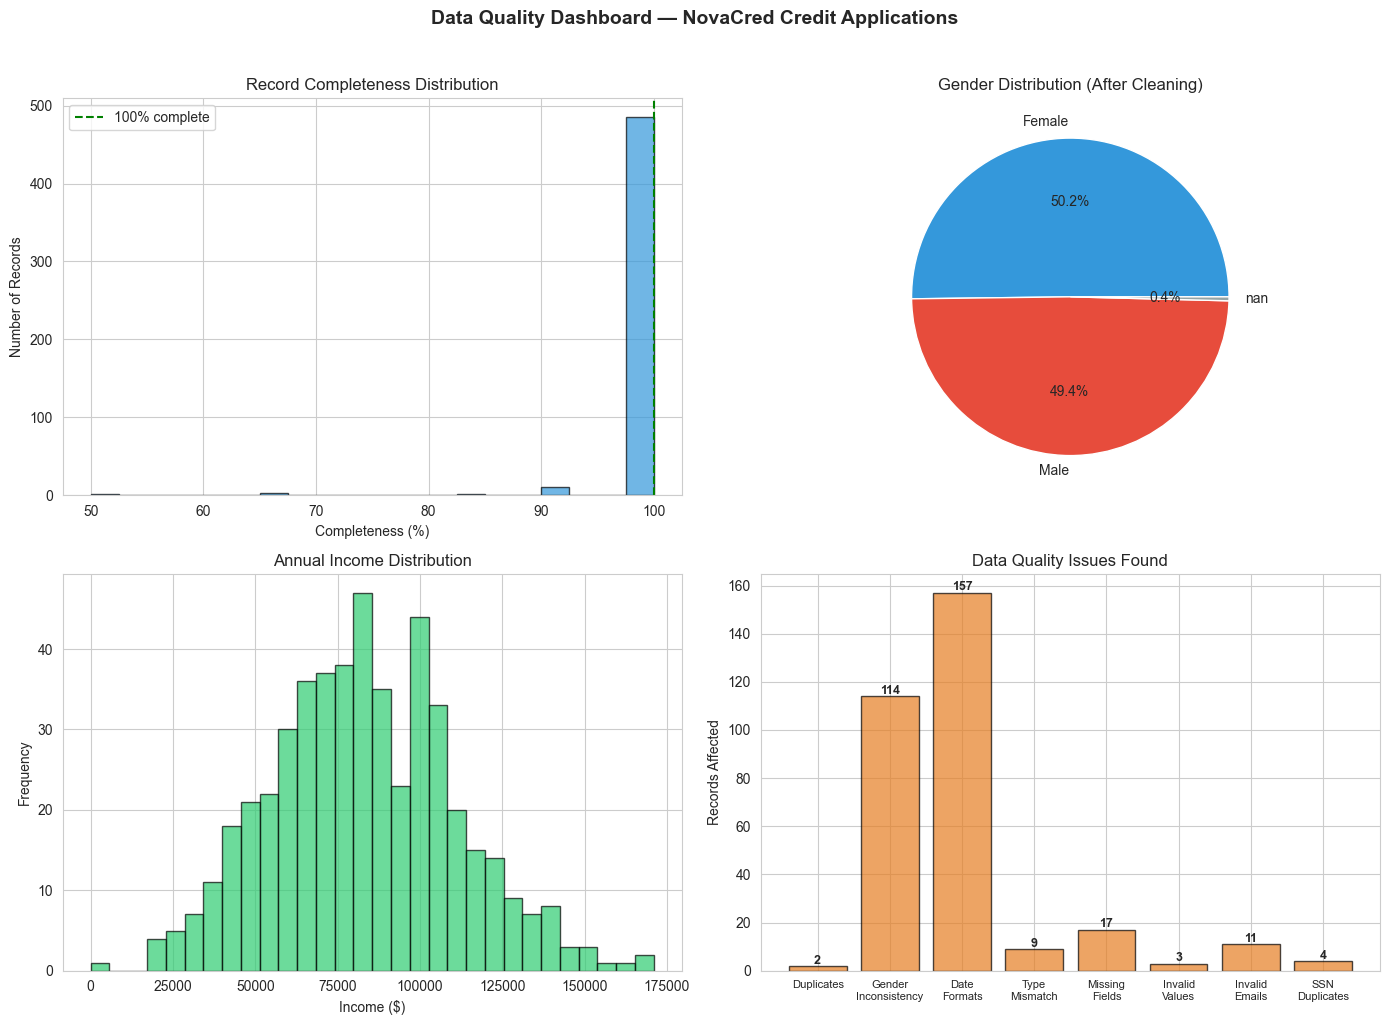

In [25]:
# Final data quality dashboard
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. completeness score distribution
axes[0,0].hist(df_clean['completeness_pct'], bins=20, color='#3498db', edgecolor='black', alpha=0.7)
axes[0,0].set_title('Record Completeness Distribution')
axes[0,0].set_xlabel('Completeness (%)')
axes[0,0].set_ylabel('Number of Records')
axes[0,0].axvline(x=100, color='green', linestyle='--', label='100% complete')
axes[0,0].legend()

# 2. gender distribution after cleaning
df_clean['gender'].value_counts(dropna=False).plot(kind='pie', ax=axes[0,1], autopct='%1.1f%%', 
                                                     colors=['#3498db', '#e74c3c', '#95a5a6'])
axes[0,1].set_title('Gender Distribution (After Cleaning)')
axes[0,1].set_ylabel('')

# 3. income distribution
axes[1,0].hist(df_clean['annual_income'].dropna(), bins=30, color='#2ecc71', edgecolor='black', alpha=0.7)
axes[1,0].set_title('Annual Income Distribution')
axes[1,0].set_xlabel('Income ($)')
axes[1,0].set_ylabel('Frequency')

# 4. issues by category
issue_cats = ['Duplicates', 'Gender\nInconsistency', 'Date\nFormats', 'Type\nMismatch', 
              'Missing\nFields', 'Invalid\nValues', 'Invalid\nEmails', 'SSN\nDuplicates']
issue_counts = [2, 114, 157, 9, 17, 3, 11, 4]
bars = axes[1,1].bar(issue_cats, issue_counts, color='#e67e22', edgecolor='black', alpha=0.7)
axes[1,1].set_title('Data Quality Issues Found')
axes[1,1].set_ylabel('Records Affected')
axes[1,1].tick_params(axis='x', rotation=0, labelsize=8)
for bar, count in zip(bars, issue_counts):
    axes[1,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                   str(count), ha='center', fontweight='bold', fontsize=9)

plt.suptitle('Data Quality Dashboard — NovaCred Credit Applications', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../reports/data_quality_dashboard.png', dpi=150, bbox_inches='tight')
plt.show()

## 15. Cleaned Data — Ready for Downstream Analysis

The cleaned dataset is saved to `data/cleaned_credit_applications.csv` and is ready for:
- **Bias analysis** (notebook 02) — uses standardized gender, normalized dates for age analysis
- **Privacy demo** (notebook 03) — PII fields identified and ready for pseudonymization

### Key Notes for Downstream Users
- Gender is now `Male`/`Female`/`NaN` — 2 records have unknown gender
- `date_of_birth` is now a proper datetime — 4 records have NaT
- `annual_income` has 5 NaN values — handle appropriately in analysis
- `email_valid` column flags records with invalid email addresses
- `ssn_duplicate_flag` marks records where SSN appears on different people
- `completeness_pct` gives a per-record quality score (0-100%)
- Original values preserved in `gender_original` and `date_of_birth_original` columns